In [37]:
from pathlib import Path

# absolute root of the repo
PROJECT_ROOT = Path(r"C:\FYP\PROJECT")

# audio_preprocessing module root
AUDIO_PREPROC_ROOT = PROJECT_ROOT / "product" / "audio_preprocessing"

# dataset locations
AUDIO_DIR = AUDIO_PREPROC_ROOT / "data" / "ESC-50" / "audio"

# output locations
AUG_AUDIO_OUT = AUDIO_PREPROC_ROOT / "outputs" / "augmented_audio"
AUG_SPEC_OUT  = AUDIO_PREPROC_ROOT / "outputs" / "augmented_spectrograms"

AUG_AUDIO_OUT.mkdir(parents=True, exist_ok=True)
AUG_SPEC_OUT.mkdir(parents=True, exist_ok=True)

print("AUDIO_DIR      =", AUDIO_DIR)
print("AUG_AUDIO_OUT  =", AUG_AUDIO_OUT)
print("AUG_SPEC_OUT   =", AUG_SPEC_OUT)
print("AUDIO_DIR exists? ", AUDIO_DIR.exists())


AUDIO_DIR      = C:\FYP\PROJECT\product\audio_preprocessing\data\ESC-50\audio
AUG_AUDIO_OUT  = C:\FYP\PROJECT\product\audio_preprocessing\outputs\augmented_audio
AUG_SPEC_OUT   = C:\FYP\PROJECT\product\audio_preprocessing\outputs\augmented_spectrograms
AUDIO_DIR exists?  True


In [32]:
#choose 1–2 demo files to verify paths
SAMPLE_FILES = [
    "1-100032-A-0.wav",
    "1-100038-A-14.wav"
]

for f in SAMPLE_FILES:
    p = AUDIO_DIR / f
    print("Exists?", p, p.exists())


Exists? C:\FYP\PROJECT\product\audio_preprocessing\data\ESC-50\audio\1-100032-A-0.wav True
Exists? C:\FYP\PROJECT\product\audio_preprocessing\data\ESC-50\audio\1-100038-A-14.wav True


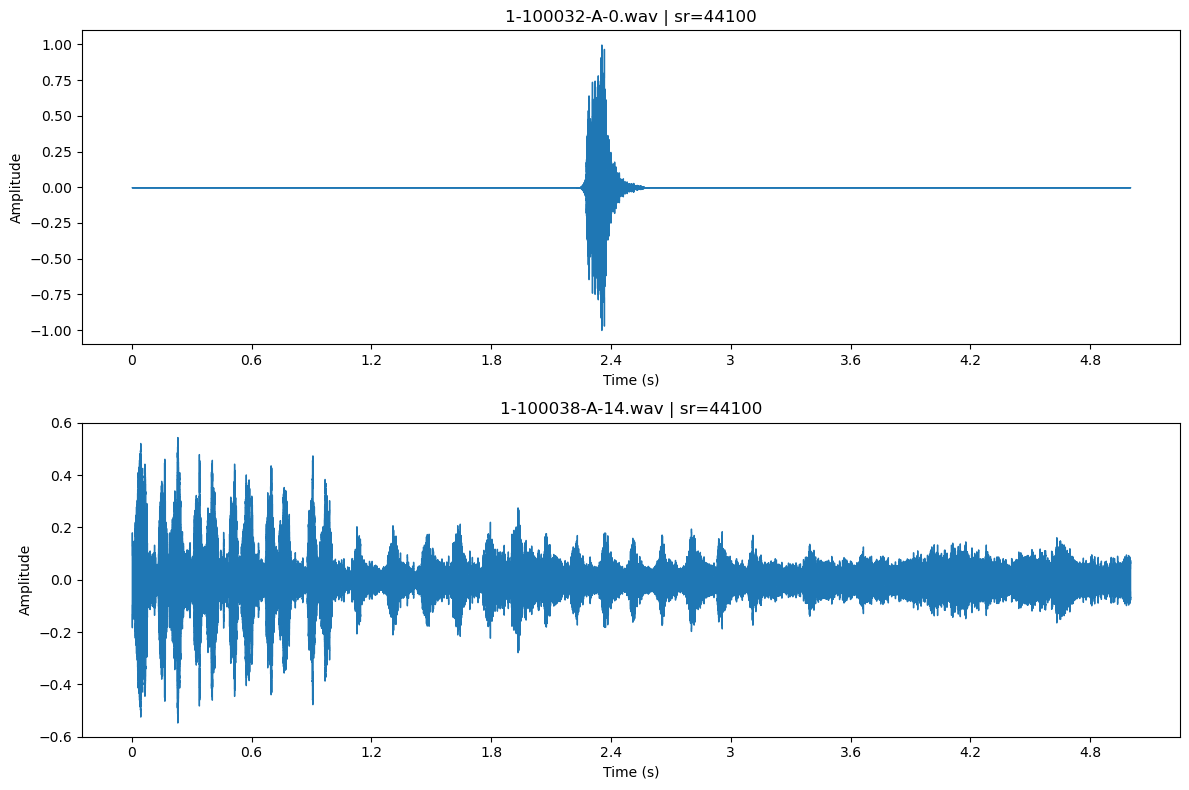

Saved waveform image to: example_waveforms.png


In [33]:
#plot + save waveforms exactly like 01_load_and_visualize did
plt.figure(figsize=(12, 4 * len(SAMPLE_FILES)))

for i, f in enumerate(SAMPLE_FILES, start=1):
    wav_path = AUDIO_DIR / f
    y, sr = librosa.load(wav_path, sr=None)

    plt.subplot(len(SAMPLE_FILES), 1, i)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{f} | sr={sr}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()

waveform_png = "example_waveforms.png"
plt.savefig(waveform_png, dpi=150, bbox_inches="tight")
plt.show()

print("Saved waveform image to:", waveform_png)


In [39]:
# basic mel-spectrogram save (match style from 02_melspectrograms)
from pathlib import Path
SPEC_OUT = Path(r"C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms")
SPEC_OUT.mkdir(parents=True, exist_ok=True)
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

for f in SAMPLE_FILES:
    wav_path = AUDIO_DIR / f
    y, sr = librosa.load(wav_path, sr=None)

    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=0,
        fmax=sr/2
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12,4))
    librosa.display.specshow(
        S_db,
        sr=sr,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        cmap='magma'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Log-Mel Spectrogram: {f}")
    plt.tight_layout()

    out_path = SPEC_OUT / f"{f.replace('.wav', '_orig.png')}"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()

    print(f"Saved spectrogram → {out_path}")


Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100032-A-0_orig.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100038-A-14_orig.png


In [40]:
#augmentation functions (nothing fancy, just basics for testing)
def augment_add_noise(y, snr_db=25):
    rms_signal = np.sqrt(np.mean(y**2))
    rms_noise = rms_signal / (10**(snr_db/20.0))
    noise = np.random.normal(0, rms_noise, size=y.shape)
    return y + noise

def augment_pitch_up(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def augment_stretch(y, rate=0.9):
    if len(y) < 2:
        return y
    return librosa.effects.time_stretch(y, rate=rate)


In [41]:
#generate + save augmented spectrograms for those same SAMPLE_FILES
for f in SAMPLE_FILES:
    wav_path = AUDIO_DIR / f
    y, sr = librosa.load(wav_path, sr=None)

    versions = {
        "noisy": augment_add_noise(y),
        "pitchUp2": augment_pitch_up(y, sr, n_steps=2),
        "stretch0.9": augment_stretch(y, rate=0.9)
    }

    for tag, y_aug in versions.items():
        S = librosa.feature.melspectrogram(
            y=y_aug,
            sr=sr,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            fmin=0,
            fmax=sr/2
        )
        S_db = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(12,4))
        librosa.display.specshow(
            S_db,
            sr=sr,
            hop_length=HOP_LENGTH,
            x_axis='time',
            y_axis='mel',
            cmap='magma'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{f} [{tag}]")
        plt.tight_layout()

        out_path = SPEC_OUT / f"{f.replace('.wav', f'_{tag}.png')}"
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close()

        print(f"Saved spectrogram → {out_path}")


Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100032-A-0_noisy.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100032-A-0_pitchUp2.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100032-A-0_stretch0.9.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100038-A-14_noisy.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100038-A-14_pitchUp2.png
Saved spectrogram → C:\FYP\PROJECT\product\audio_preprocessing\outputs\spectrograms\1-100038-A-14_stretch0.9.png
